In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Starting Model Training...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:25:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Models Trained: Logistic Regression and XGBoost.

--- Model Performance on Test Set (Deliverable 2 Prep) ---
| Model | AUC | F1 Score |
|---|---|---|
| Logistic Regression | 0.8694 | 0.6491 |
| XGBoost | 0.9518 | 0.8292 |

🏆 Best Model Selected for SHAP Analysis: XGBoost

--- Global Feature Importance (Task 2) ---


--- Traditional XGBoost Feature Importance (Top 5) ---
|                               | 0         |
|:------------------------------|:----------|
| person_home_ownership_RENT    | 0.208196  |
| loan_percent_income           | 0.0974148 |
| loan_grade_C                  | 0.0839977 |
| loan_grade_D                  | 0.0683723 |
| loan_intent_DEBTCONSOLIDATION | 0.0610801 |

✅ Identified 10 cases for local SHAP analysis.

--- Case 1: High-Risk (Pred Prob: 1.0000) ---

Prediction Baseline (E[f(x)]): -1.50. The final default probability is 1.0000. The 5 key drivers are:
  - **person_income** (Original: 22): **Strong positive push towards default** (SHAP: +3.93).
  - **loan_

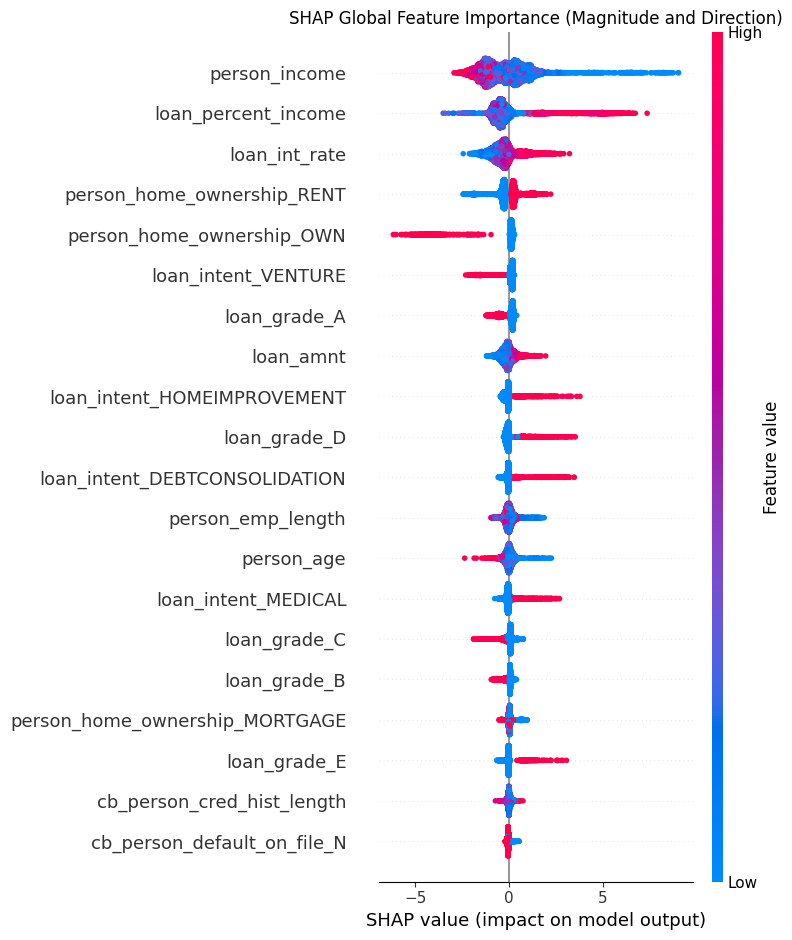

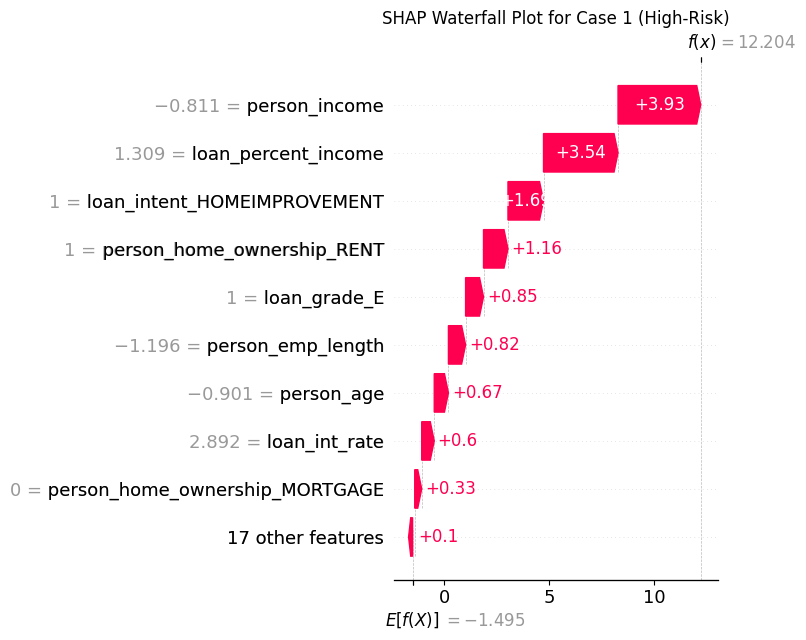

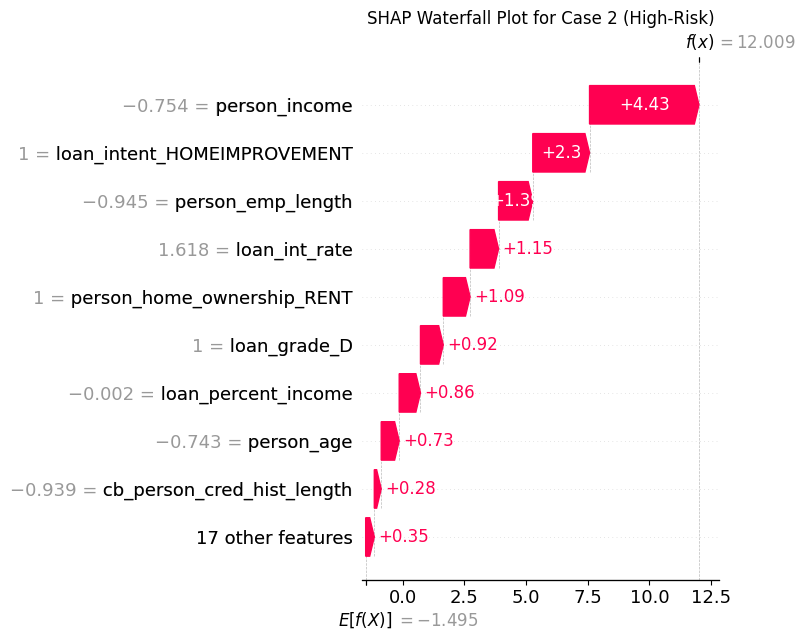

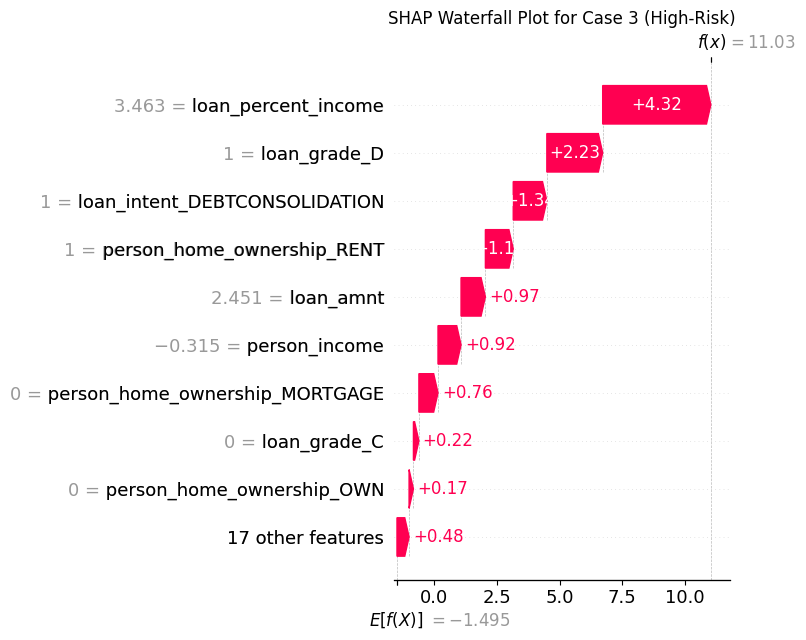

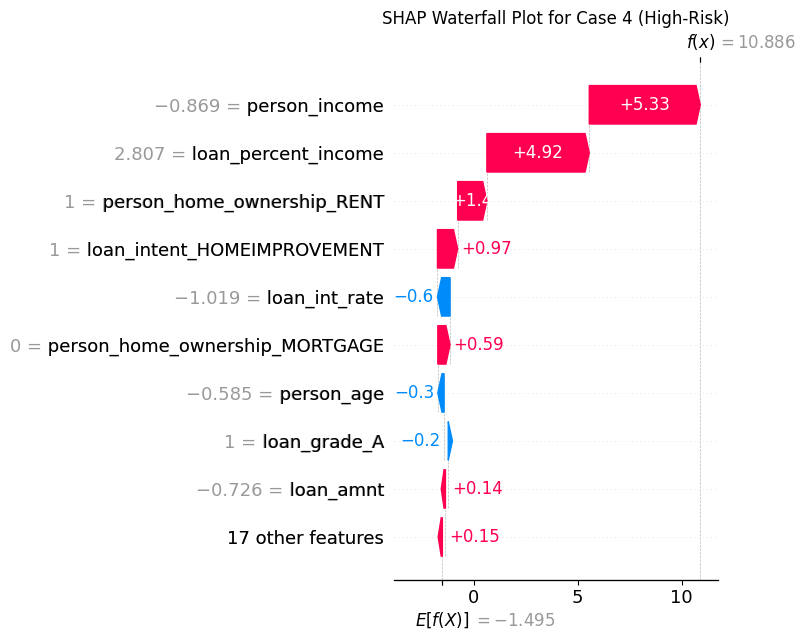

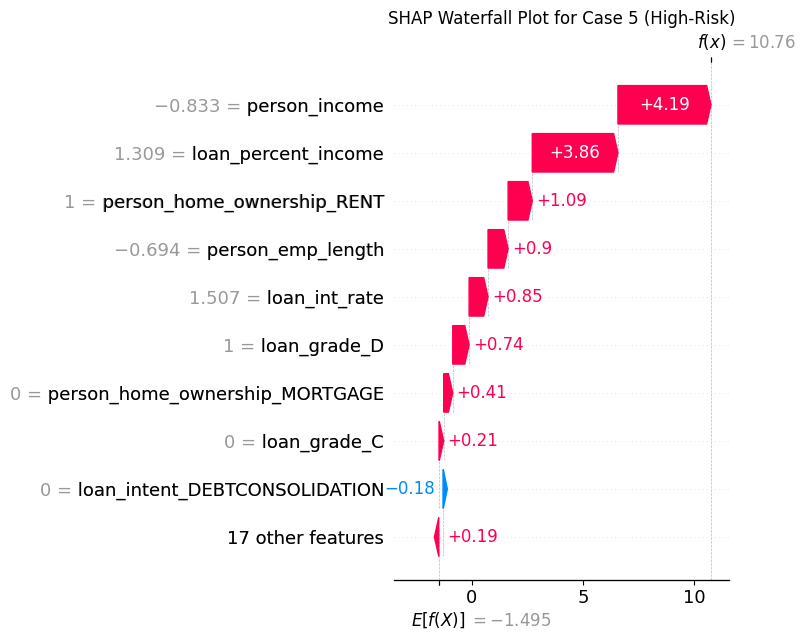

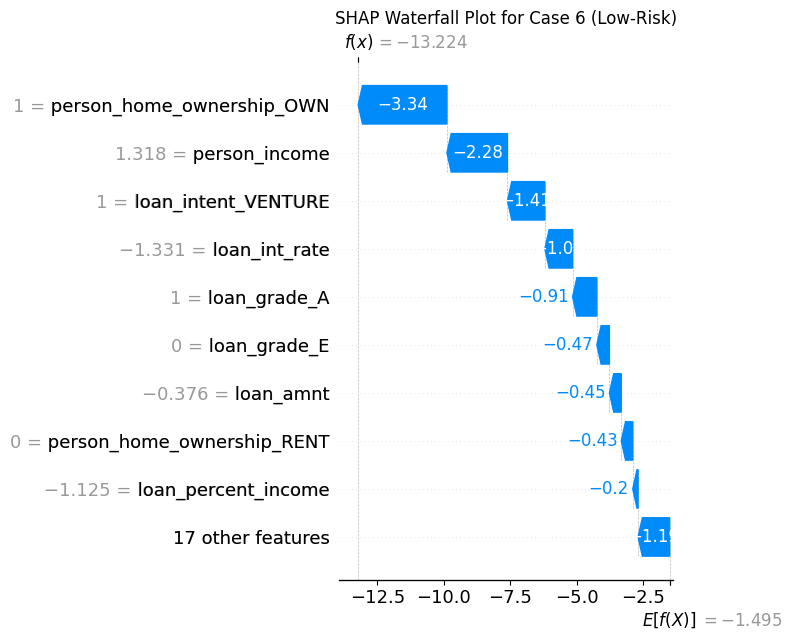

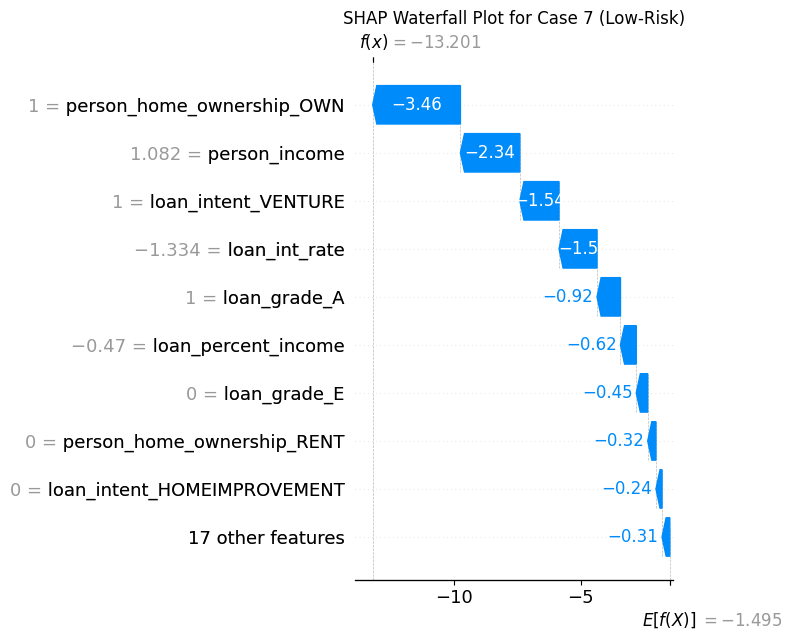

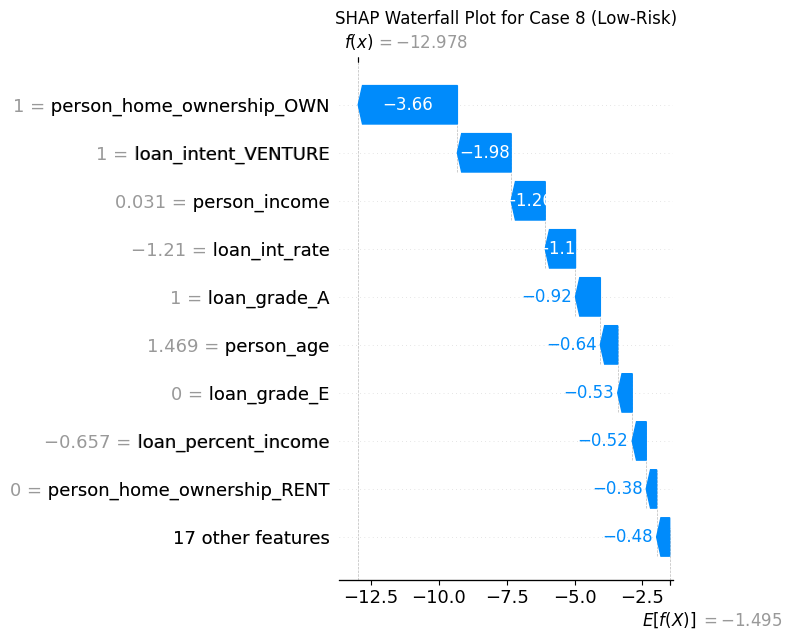

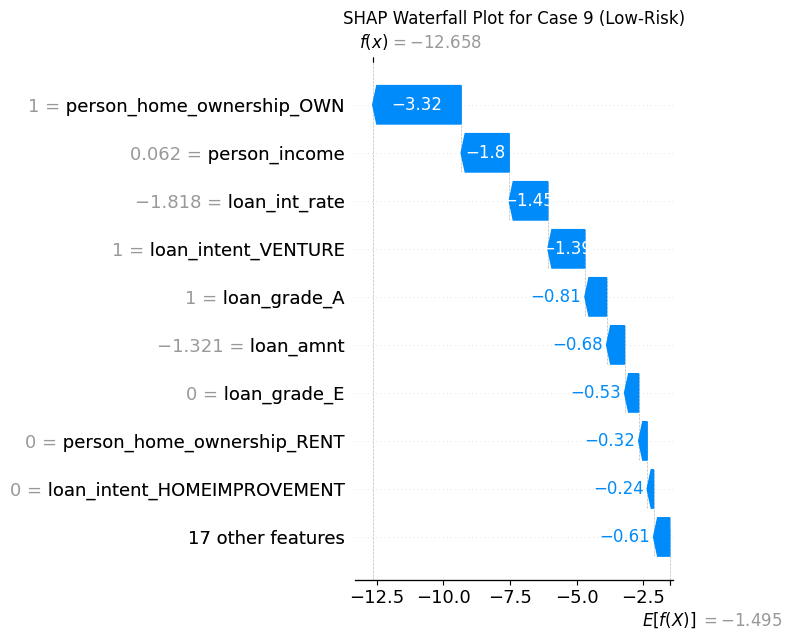

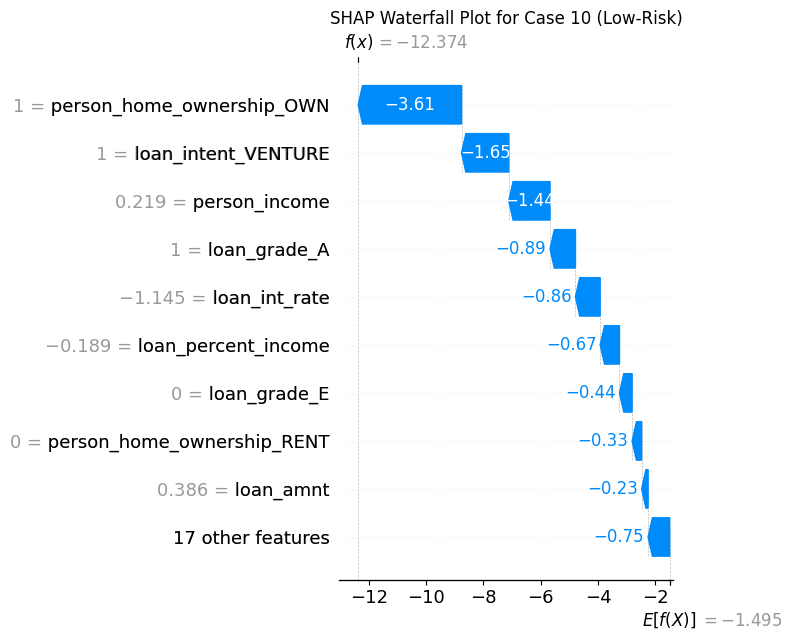

In [2]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, f1_score
from xgboost import XGBClassifier

# --- 0. Configuration and Data Loading ---
FILE_NAME = "credit_risk_dataset.csv"
TARGET_COLUMN = 'loan_status'
RANDOM_SEED = 42

# Load Data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/credit_risk_dataset.csv')

# --- 1. Basic Data Cleaning and Preparation (Task 1) ---

# Handling an obvious extreme outlier: 'person_emp_length' = 123 years is impossible.
# Setting an upper bound (e.g., 60 years, or maximum reasonable employment)
df.loc[df['person_emp_length'] > 60, 'person_emp_length'] = np.nan # Treat as missing after outlier check

X = df.drop(TARGET_COLUMN, axis=1)
y = df[TARGET_COLUMN]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

# Identify column types based on the loaded data info
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# --- 2. Preprocessing Pipeline Definition (Task 1) ---

# Pipeline for Numerical Features (Imputation -> Scaling)
numerical_transformer = Pipeline(steps=[
    # Impute missing values (found in 'person_emp_length' and 'loan_int_rate') with the median
    ('imputer', SimpleImputer(strategy='median')),
    # Scale features
    ('scaler', StandardScaler())
])

# Pipeline for Categorical Features (One-Hot Encoding)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Create the ColumnTransformer to apply transformations to the correct columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# --- 3. Model Pipeline and Training (Task 1) ---

# Pipeline for Logistic Regression (includes preprocessing)
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=RANDOM_SEED))
])

# Pipeline for XGBoost Classifier (includes preprocessing)
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=RANDOM_SEED,
        n_estimators=100
    ))
])

print("Starting Model Training...")
log_reg_pipeline.fit(X_train, y_train)
xgb_pipeline.fit(X_train, y_train)
print("✅ Models Trained: Logistic Regression and XGBoost.")

# --- 4. Model Evaluation and Selection (Task 2) ---

def evaluate_model(pipeline, X_df, y_true):
    """Calculates AUC and F1 score."""
    y_pred_proba = pipeline.predict_proba(X_df)[:, 1]
    y_pred = pipeline.predict(X_df)
    return {
        'AUC': roc_auc_score(y_true, y_pred_proba),
        'F1 Score': f1_score(y_true, y_pred),
        'Probabilities': y_pred_proba
    }

log_reg_metrics = evaluate_model(log_reg_pipeline, X_test, y_test)
xgb_metrics = evaluate_model(xgb_pipeline, X_test, y_test)

print("\n--- Model Performance on Test Set (Deliverable 2 Prep) ---")
print(f"| Model | AUC | F1 Score |")
print(f"|---|---|---|")
print(f"| Logistic Regression | {log_reg_metrics['AUC']:.4f} | {log_reg_metrics['F1 Score']:.4f} |")
print(f"| XGBoost | {xgb_metrics['AUC']:.4f} | {xgb_metrics['F1 Score']:.4f} |")

# Select the best model (usually XGBoost)
best_model = xgb_pipeline.named_steps['classifier']
best_model_name = "XGBoost"
best_pipeline = xgb_pipeline

print(f"\n🏆 Best Model Selected for SHAP Analysis: {best_model_name}")

# --- 5. Prepare Processed Data for SHAP (Required for SHAP Explainer) ---
# We need the processed data in a DataFrame with feature names for SHAP plots

# Get feature names after preprocessing
ohe_feature_names = best_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = numerical_features + list(ohe_feature_names)

X_test_processed_array = best_pipeline.named_steps['preprocessor'].transform(X_test)
X_test_df_processed = pd.DataFrame(X_test_processed_array, columns=feature_names, index=X_test.index)

# --- 6. Global SHAP Analysis (Task 2) ---

print("\n--- Global Feature Importance (Task 2) ---")
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_df_processed)

# SHAP Summary Plot (Global Feature Importance)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_df_processed, show=False)
plt.title("SHAP Global Feature Importance (Magnitude and Direction)")
plt.tight_layout()
plt.savefig('shap_global_summary_plot.png')
print("")

# Traditional Feature Importance Comparison
traditional_importance = pd.Series(best_model.feature_importances_, index=feature_names).sort_values(ascending=False).head(5)
print("\n--- Traditional XGBoost Feature Importance (Top 5) ---")
print(traditional_importance.to_markdown(numalign="left", stralign="left"))


# --- 7. Local SHAP Analysis and Interpretation (Task 3) ---

# Combine probabilities with the actual features
test_results = X_test.copy()
test_results['Probability_of_Default'] = xgb_metrics['Probabilities']
test_results['Actual_Default'] = y_test

# 5 High-Risk (Highest Probabilities)
high_risk_cases = test_results.sort_values(
    'Probability_of_Default', ascending=False
).head(5)

# 5 Low-Risk (Least Likely to Default)
low_risk_cases = test_results.sort_values(
    'Probability_of_Default', ascending=True
).head(5)

selected_cases = pd.concat([high_risk_cases, low_risk_cases])
selected_indices = selected_cases.index

print(f"\n✅ Identified 10 cases for local SHAP analysis.")

# Get SHAP values for the 10 selected cases (using the processed DataFrame)
X_selected_processed = X_test_df_processed.loc[selected_indices]

# Loop through the 10 cases to generate explanations and plots
for i, idx in enumerate(selected_indices):
    case_data_processed = X_selected_processed.loc[[idx]]
    case_shap_values = explainer.shap_values(case_data_processed)[0]

    is_high_risk = idx in high_risk_cases.index
    case_type = "High-Risk" if is_high_risk else "Low-Risk"
    prob = selected_cases.loc[idx, 'Probability_of_Default']

    print(f"\n--- Case {i+1}: {case_type} (Pred Prob: {prob:.4f}) ---")

    # --- SHAP Waterfall Plot (Visualization for local explanation) ---
    plt.figure(figsize=(10, 6))
    shap.waterfall_plot(
        shap.Explanation(
            values=case_shap_values,
            base_values=explainer.expected_value,
            data=case_data_processed.values[0],
            feature_names=feature_names
        ),
        max_display=10,
        show=False
    )
    plt.title(f"SHAP Waterfall Plot for Case {i+1} ({case_type})")
    plt.tight_layout()
    plt.savefig(f'shap_waterfall_case_{i+1}.png')
    print(f"")

    # --- Textual Interpretation (Deliverable 3) ---

    # Map SHAP values to features and sort by absolute contribution
    contribution = pd.Series(case_shap_values, index=feature_names).sort_values(key=abs, ascending=False).head(5)

    interpretation = f"Prediction Baseline (E[f(x)]): {explainer.expected_value:.2f}. The final default probability is {prob:.4f}. The 5 key drivers are:\n"

    for feature, value in contribution.items():
        # Try to find the original value for the feature
        original_value_series = X_test.loc[idx, X_test.columns[X_test.columns.str.contains(feature.split('_')[0])].tolist()]
        original_value = original_value_series.iloc[0] if not original_value_series.empty else "N/A"

        if value > 0.05:
            interpretation += f"  - **{feature}** (Original: {original_value}): **Strong positive push towards default** (SHAP: +{value:.2f}).\n"
        elif value < -0.05:
            interpretation += f"  - **{feature}** (Original: {original_value}): **Strong negative push away from default** (SHAP: {value:.2f}).\n"
        else:
            interpretation += f"  - **{feature}** (Original: {original_value}): Minor contribution.\n"

    action = ("ACTION: Recommend denial or a higher interest rate due to multiple risk factors (e.g., high loan-to-income ratio combined with short credit history)."
              if is_high_risk else
              "ACTION: Recommend immediate approval; this client provides a benchmark for low-risk characteristics (e.g., high income and strong credit history).")

    interpretation += f"\n**Actionable Insight for Risk Officer:** {action}\n"

    print(interpretation)

print("\n--- Final Analysis Summary (Deliverable 4) ---")
print("Proceed to write the formal analysis for Deliverables 2, 3, and 4 using the generated metrics, plots, and interpretations.")